In [1]:
import tensorflow as tf
print(tf.test.gpu_device_name())
!/opt/bin/nvidia-smi

/device:GPU:0
Wed Nov 20 14:08:53 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    72W / 149W |     69MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Mem

In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.utils import np_utils
from tensorflow.keras.layers import Input,BatchNormalization,Conv3D,MaxPooling3D,AveragePooling3D,Dropout,Flatten,Activation,add,Dense,Average,AveragePooling3D,Concatenate,Conv1D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import  load_model,Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
import random
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,EarlyStopping,ReduceLROnPlateau


Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
os.chdir('/content/drive/My Drive/Colab Notebooks')

In [0]:

label_dic = {
        'd':0,
        'drink':0,
        'e':1,
        'eat':1,
        'groomback':1,
        'gb':1,
        'g':1,
        'groom':1,
        'hang':2,
        'ha':2,
        'head':3,
        'he':3,
        'r':4,
        'rear':4,
        'rest':5,
        'rs':6,
        'w':7,
        'walk':7
        }


classes= ['drink','eat','groom','hang','micromovement','rear','rest','walk']
num_classes= len(classes)

data_path = '/content/drive/My Drive/Colab Notebooks/clipped_database_1/clipped_database/'


video_path_train={}
video_class_train={}
video_path_test = {}
video_class_test={}

index = 0
for i in os.listdir(data_path):
    #print(i)
    if os.path.isdir(data_path+i) and i!='20080420124815':
        for j in os.listdir(data_path+i):
            #print(j)
            file_name=j
            video_path_train[index]=data_path+i+'/'+j
            file_name=file_name.split('_')
            video_class_train[index]=label_dic[file_name[1].strip().lower()]
            index = index+1

for i in os.listdir(data_path):
    if os.path.isdir(data_path+i) and i=='20080420124815':
        for j in os.listdir(data_path+i):
            file_name=j
            video_path_test[index]=data_path+i+'/'+j
            file_name=file_name.split('_')
            video_class_test[index]=label_dic[file_name[1].strip().lower()]
            index = index+1

In [0]:
print(f"Total number of sample video segments to train: {len(video_path_train)}")
print(f"Total number of sample video segments to test: {len(video_path_test)}")

Total number of sample video segments to train: 3976
Total number of sample video segments to test: 292


In [0]:
momentum=0.9
epsilon = 0.0005
learning_rate = 0.0001
ra = 0.1
img_width=190
img_height=120
img_depth = 16

In [0]:
class DataGenerator:
  def __init__(self,width,height,depth,data_list,batch_size=32,nchannels=1):
    self.width = width
    self.height = height
    self.depth = depth
    self.batch_size=batch_size
    self.data_list=data_list
    self.cur_train_index=0
    self.channels = nchannels
  def get_data(self,filename,skip=True):
    #print(filename)
    cap=cv2.VideoCapture(filename)
    nframe=cap.get(cv2.CAP_PROP_FRAME_COUNT)
    #print(nframe)
    bAppend = False 
    if(nframe>self.depth):
      if skip:
         #Random skip frames to select 
         s = np.random.randint(int(nframe/self.depth))+1
         #print(s)
         frames=[x*s for x in range(self.depth)]
      else:
        frames = [x for x in range(self.depth)]
    else:
      #print("Insufficient %d frames in video %s, appending the frames" %(nframe,filename))
      bAppend = True
      frames = [x for x in range(int(nframe))] 
    framearray = []
    opticarray=[]
    
    if not bAppend:
      for i in range(len(frames)):
        #print(i,frames[i])
        cap.set(cv2.CAP_PROP_POS_FRAMES,frames[i])
        ret,frame=cap.read()
        #print(frame.shape)
        if ret:
          frame = cv2.resize(frame,(self.width,self.height))
          framearray.append(cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY))      
    else:
      frame=''
      while True:
        ret,frame=cap.read()
        #print(len(framearray))
        if ret:
          frame = cv2.resize(frame,(self.width,self.height))
          framearray.append(cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY))
        else:
          break
      if len(framearray)==0:
        print(filename,nframe)    
      frame=framearray[-1]
      #print(frame.shape)
    cap.release()
    if bAppend:
      while len(framearray)<self.depth:
        framearray.append(frame)

    for i in range(1,len(framearray)):
      flow=cv2.calcOpticalFlowFarneback(framearray[i-1],framearray[i],flow=None,pyr_scale=0.5,levels=5,winsize=11,iterations=10,poly_n=5,poly_sigma=1.1,flags=0)
      flow_x=np.array(flow[...,0])
      flow_y=np.array(flow[...,1])
      flow_temp = flow_x+flow_y
      opticarray.append(flow_temp)
    
    for i in range(len(framearray)):
      framearray[i]=framearray[i]/255
    return np.array(framearray),np.array(opticarray)

  def loaddata_train(self):
    while 1:
      video_frames=[]
      video_optics=[]
      labels=[]
      for i in range(self.batch_size):
        if self.cur_train_index >= len(self.data_list):
          self.cur_train_index=0
        filename = video_path_train[self.data_list[self.cur_train_index]]
        label = video_class_train[self.data_list[self.cur_train_index]]
        video,optic =  self.get_data(filename)
        video_frames.append(video)
        video_optics.append(optic)
        labels.append(np_utils.to_categorical(label,num_classes))
        self.cur_train_index+=1
      video_frames = np.array(video_frames).transpose((0,2,3,1))
      optic_frames = np.array(video_optics).transpose((0,2,3,1))
      labels = np.array(labels)
      video_frames = video_frames.reshape((video_frames.shape[0],self.width,self.height,self.depth,self.channels))       
      optic_frames = optic_frames.reshape((optic_frames.shape[0],self.width,self.height,self.depth-1,self.channels))
      yield ({'Input1':video_frames,'Input2':optic_frames},labels)    
    
  def loaddata_test(self):
    while 1:
      video_frames=[]
      video_optics=[]
      labels=[]
      for i in range(self.batch_size):
        if self.cur_train_index >= len(self.data_list):
          self.cur_train_index=0
        filename = video_path_test[self.data_list[self.cur_train_index]]
        label = video_class_test[self.data_list[self.cur_train_index]]
        video,optic =  self.get_data(filename)
        video_frames.append(video)
        video_optics.append(optic)
        labels.append(np_utils.to_categorical(label,num_classes))
        self.cur_train_index+=1
      video_frames = np.array(video_frames).transpose((0,2,3,1))
      optic_frames = np.array(video_optics).transpose((0,2,3,1))
      labels = np.array(labels)
      video_frames = video_frames.reshape((video_frames.shape[0],self.width,self.height,self.depth,self.channels))       
      optic_frames = optic_frames.reshape((optic_frames.shape[0],self.width,self.height,self.depth-1,self.channels))  
      yield ({'Input1':video_frames,'Input2':optic_frames},labels)
  #Data generator for prediction
  #data contains the list of file name
  def loaddata(self,data):
    while 1:
      video_frames=[]
      video_optics=[]
      for i in range(self.batch_size):
        if self.cur_train_index>=len(self.data_list):
          self.cur_train_index=0
        filename=data[self.data_list[self.cur_train_index]]
        video,optic =  self.get_data(filename)
        video_frames.append(video)
        video_optics.append(optic)
        self.cur_train_index+=1
      video_frames = np.array(video_frames).transpose((0,2,3,1))
      optic_frames = np.array(video_optics).transpose((0,2,3,1))
      video_frames = video_frames.reshape((video_frames.shape[0],self.width,self.height,self.depth,self.channels))       
      optic_frames = optic_frames.reshape((optic_frames.shape[0],self.width,self.height,self.depth-1,self.channels))  
      yield ({'Input1':video_frames,'Input2':optic_frames})         

In [0]:
data_list_train = list(video_path_train.keys())
random.shuffle(data_list_train)

data_list_test = list(video_path_test.keys())
random.shuffle(data_list_test)

In [0]:
def simple_residual(Inp,num_filters,kernel_size=3):
  #Temporal space
  x=Conv3D(num_filters,(kernel_size,kernel_size,1),padding='same',use_bias=False)(Inp)
  x = BatchNormalization(axis=-1,momentum=momentum,epsilon=epsilon)(x)
  x = Activation('relu')(x)
  #for temporal analysis
  x = Conv3D(num_filters,kernel_size=(1,1,kernel_size),padding='same',use_bias=False)(x)
  x = BatchNormalization(axis=-1,momentum=momentum,epsilon=epsilon)(x)
  x = Activation('relu')(x)
  return x


In [0]:
def conv2D1D(Inp,num_filters,kernel_size=3):
  x =Conv3D(num_filters,(kernel_size,kernel_size,1),padding='same',use_bias=False)(Inp)
  x = BatchNormalization(axis=-1,momentum=momentum,epsilon=epsilon)(x)
  x = Activation('relu')(x)
  #for temporal analysis
  x = Conv3D(num_filters,kernel_size=(1,1,kernel_size),padding='same',use_bias=False)(x)
  x = BatchNormalization(axis=-1,momentum=momentum,epsilon=epsilon)(x)
  x = Activation('relu')(x)
  return x

In [0]:
def simple_residual_block(Inp,num_filters,kernel_size=3):
  x = Inp
  y = Inp 
  y = simple_residual(y,num_filters,kernel_size)
  x = add([x,y])
  return x 

In [0]:
def downsample_residual(Inp,num_filters,kernel_size=3):
  x = Conv3D(num_filters,(kernel_size,kernel_size,1),strides=(2,2,1),padding='same',use_bias=False)(Inp)
  x = BatchNormalization(axis=-1,momentum=momentum,epsilon=epsilon)(x)
  x = Activation('relu')(x)
  x = Conv3D(num_filters,kernel_size=(1,1,kernel_size),strides=(1,1,2),padding='same',use_bias=False)(x)
  x = BatchNormalization(axis=-1,momentum=momentum,epsilon=epsilon)(x)
  x = Activation('relu')(x)
  return x

In [0]:
def simple_downsampleConv3D(Inp,num_filters,kernel_size=3):
  x = Conv3D(num_filters,(kernel_size,kernel_size,kernel_size),padding='same',use_bias=False)(Inp)
  x = BatchNormalization(axis=-1,momentum=momentum,epsilon=epsilon)(x)
  x = Activation('relu')(x)
  return x

In [0]:
def simple_conv3D(Inp,num_filters,kernel_size=3):
  x = Conv3D(num_filters,(kernel_size,kernel_size,kernel_size),padding='same',use_bias=False)(Inp)
  x = BatchNormalization(axis=-1,momentum=momentum,epsilon=epsilon)(x)
  x = Activation('relu')(x)
  return x

In [0]:
def downsample_residualBlk(Inp,num_filters,kernel_size=3):
  x = Inp
  y = Inp
  y = downsample_residual(y,num_filters,kernel_size=kernel_size)
  x = downsample_residual(x,num_filters,kernel_size=1)
  x = add([x,y])
  return x

In [0]:
def feature_extractor_module_video():
  Inp = Input(shape=(img_width,img_height,img_depth,1),name='Input')
  x = conv2D1D(Inp,32)
  #x = simple_conv3D(Inp,32)
  for _ in range(2):
    x = simple_residual_block(x,32)
  #down factor by 2: 8
  x = downsample_residualBlk(x,32)
  #x = simple_conv3D(Inp,64)
  x = conv2D1D(x,64)
  for _ in range(2):
    x = simple_residual_block(x,64)
  x = downsample_residualBlk(x,64)
  #x =  simple_conv3D(x,128)
  x = conv2D1D(x,128)
  for _ in range(4):
    x = simple_residual_block(x,128)
  #down factor by 2: 4  
  x = downsample_residualBlk(x,128)
  #x =  simple_conv3D(x,256)
  x = conv2D1D(x,256)
  for _ in range(8):
    x = simple_residual_block(x,256)
  #down factor by 2: 4    
  x = downsample_residualBlk(x,256)
  #x =  simple_conv3D(x,512)
  x = conv2D1D(x,512)
  for _ in range(8):
    x = simple_residual_block(x,512)
  x = downsample_residualBlk(x,512)
  #x =  simple_conv3D(x,1024)
  x = conv2D1D(x,1024)
  for _ in range(4):
    x = simple_residual_block(x,1024)
  x = conv2D1D(x,2048)
  #x = AveragePooling3D(pool_size=(3,3,3))(x)
  x = Dropout(0.2)(x)
  x = Flatten(name='flatten_feature')(x)
  #x = AveragePooling1D(pool_size=3)(x)
  model = Model(inputs = Inp,outputs=x)
  return model




    


In [0]:
def feature_extractor_module_optic():
  Inp = Input(shape=(img_width,img_height,img_depth,1),name='Input')
  x = conv2D1D(Inp,32)
  #x = simple_conv3D(Inp,32)
  for _ in range(2):
    x = simple_residual_block(x,32)
  #down factor by 2: 8
  x = downsample_residualBlk(x,32)
  #x = simple_conv3D(Inp,64)
  x = conv2D1D(x,64)
  for _ in range(2):
    x = simple_residual_block(x,64)
  x = downsample_residualBlk(x,64)
  #x =  simple_conv3D(x,128)
  x = conv2D1D(x,128)
  for _ in range(4):
    x = simple_residual_block(x,128)
  #down factor by 2: 4  
  x = downsample_residualBlk(x,128)
  #x =  simple_conv3D(x,256)
  x = conv2D1D(x,256)
  for _ in range(8):
    x = simple_residual_block(x,256)
  #down factor by 2: 4    
  x = downsample_residualBlk(x,256)
  #x =  simple_conv3D(x,512)
  x = conv2D1D(x,512)
  for _ in range(8):
    x = simple_residual_block(x,512)
  x = downsample_residualBlk(x,512)
  #x =  simple_conv3D(x,1024)
  x = conv2D1D(x,1024)
  for _ in range(4):
    x = simple_residual_block(x,1024)
  x = conv2D1D(x,2048)
  #x = AveragePooling3D(pool_size=(3,3,3))(x)
  x = Dropout(0.2)(x)
  x = Flatten(name='flatten_feature')(x)
  #x = AveragePooling1D(pool_size=3)(x)
  model = Model(inputs = Inp,outputs=x)
  return model

In [18]:
feature_motion = feature_extractor_module_video()
feature_optic = feature_extractor_module_optic()
feature_motion.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 190, 120, 16 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 190, 120, 16, 288         Input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 190, 120, 16, 128         conv3d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 190, 120, 16, 0           batch_normalization[0][0]        
_____________

In [0]:
video = Input(shape=(img_width,img_height,img_depth,1),dtype='float32',name = 'Input1')
optic = Input(shape=(img_width,img_height,img_depth-1,1),dtype='float32',name='Input2')

x1 = feature_motion(video)
x2 = feature_optic(optic)

out = Average()([x1,x2])
#out = Conv1D(32,1,1)(out)
out = Dense(256,activation='relu')(out)
out = Dense(128,activation='relu')(out)

out = Dense(num_classes,activation='softmax')(out)

#out = Dense(num_classes,activation='softmax')(out)
model = Model(inputs=[video,optic],outputs=out)
optz = optimizers.Adam(learning_rate=0.0001)


In [20]:
model_name='video_analytics_new_2'
#log_dir='/content/drive/My Drive/Colab Notebooks/'
filepath='/content/drive/My Drive/Colab Notebook/'+model_name+'.h5py'
filepath2 = '/content/drive/My Drive/Colab Notebook/video_analytics.h5py'
checkpoint = ModelCheckpoint(filepath,monitor='val_acc',save_weights_only=True,save_best_only=True)
csv_logger=CSVLogger("/content/drive/My Drive/Colab NoteBooks"+model_name+".csv")
reduce_lr = ReduceLROnPlateau(monitor='val_loss',factor=0.1,paitence=3,verbose=1)
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=40,verbose=1)
model.compile(loss='categorical_crossentropy',optimizer=optz,metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input1 (InputLayer)             [(None, 190, 120, 16 0                                            
__________________________________________________________________________________________________
Input2 (InputLayer)             [(None, 190, 120, 15 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 49152)        129658912   Input1[0][0]                     
__________________________________________________________________________________________________
model_1 (Model)                 (None, 49152)        129658912   Input2[0][0]                     
____________________________________________________________________________________________

In [21]:
batch_size=2

gen_train = DataGenerator(img_width,img_height,img_depth,data_list_train,batch_size)
gen_test = DataGenerator(img_width,img_height,img_depth,data_list_test,batch_size)
model.load_weights(filepath)

In [0]:
model.fit_generator(gen_train.loaddata_train(),steps_per_epoch = max(1,len(data_list_train)//batch_size),validation_data=gen_test.loaddata_test(),validation_steps=max(1,len(data_list_test)//batch_size),validation_freq=2,epochs=2,callbacks=[checkpoint,csv_logger,reduce_lr,early_stopping])

Epoch 1/2
1988/1988 [==============================] - 4721s 2s/step - loss: 0.3471 - acc: 0.8891
Epoch 2/2
1988/1988 [==============================] - 4928s 2s/step - loss: 0.3112 - acc: 0.8956 - val_loss: 0.2348 - val_acc: 0.9349


In [0]:
import matplotlib.pyplot as plt

In [0]:
dict1_lab = video_class_train
dict1 = video_path_train

In [0]:
dict2_lab = video_class_test
dict2 = video_path_test

In [0]:
dict1.update(dict2)
dict1_lab.update(dict2_lab)

In [0]:
y = np.array(list(dict1_lab.values()))

In [0]:
data_gen = DataGenerator(img_width,img_height,img_depth,list(dict1.keys()),batch_size=1)

In [0]:
y_pred=model.predict_generator(data_gen.loaddata(dict1),steps=len(dict1))

In [0]:
y_pred

array([[2.04738972e-04, 8.24411929e-01, 1.31331499e-05, ...,
        2.77319987e-06, 1.78192968e-05, 5.52331738e-04],
       [1.28560999e-11, 5.57337216e-06, 9.37811732e-01, ...,
        6.80802054e-15, 1.29300338e-13, 1.46422292e-06],
       [5.02418101e-01, 4.82096076e-01, 5.71587998e-06, ...,
        3.51233105e-08, 2.62455214e-05, 3.60384320e-06],
       ...,
       [7.34398640e-08, 1.72480373e-04, 9.84264433e-01, ...,
        5.67522740e-09, 9.63245483e-10, 2.03298314e-05],
       [6.79914199e-04, 1.23577535e-01, 4.93564783e-03, ...,
        1.65364341e-04, 2.73516309e-03, 2.67749399e-01],
       [5.11626014e-04, 8.32145333e-01, 1.59960455e-05, ...,
        3.04743423e-07, 1.08507602e-05, 6.97443727e-04]], dtype=float32)

In [0]:
y_test = np.argmax(y_pred,axis=-1)

In [0]:
y_test

array([1, 2, 0, ..., 2, 3, 1])

In [0]:
import sklearn.metrics as metrics

In [0]:
metrics.confusion_matrix(y,y_test)

array([[  49,   14,    0,    2,    0,    0,    0,    0],
       [  38, 1719,    4,   48,   39,    4,    4,   13],
       [   0,    0,  528,    2,    4,    0,    0,    0],
       [   3,   58,    2,   94,    0,    0,    0,   35],
       [   0,   48,    7,    3,  371,    0,    0,    0],
       [   0,   26,    0,    0,    0,  694,    0,    0],
       [   0,   18,    0,    9,    0,    0,  122,    0],
       [   0,    2,    0,    4,    0,    0,    0,  304]])

In [0]:
metrics.accuracy_score(y,y_test)*100

90.93252108716027

In [0]:
def plot_confusion_matrix(y_true,y_pred,classes,normalize=False,title=None,cmap=plt.cm.Oranges):
  if not title:
    if not normalize:
      title='Confusion Matrix'
    else:
      title='Normalized Confusion matrix'
  cm=confusion_matrix(y_true,y_pred)
  fig,ax = plt.subplots()
  im = ax.imshow(cm,interpolation='nearest',cmap=cmap)
  ax.figure.colorbar(im,ax=ax)
  ax.set(xticks=np.arange(cm.shape[1]),yticks=np.arange(cm.shape[0]),xticklabels=classes,yticklabels=classes,title=title,ylabel='True label',xlabel='Predicted label')
  plt.setp(ax.get_xticklabels(),rotation=45,ha="right",rotation_mode="anchor")
  fmt = ".2f" if normalize else 'd'
  thresh = cm.max()/2.
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      ax.text(j,i,format(cm[i,j],fmt),ha="center",va="center",color="white" if cm[i,j]> thresh else "black")
  fig.tight_layout()
  return ax    







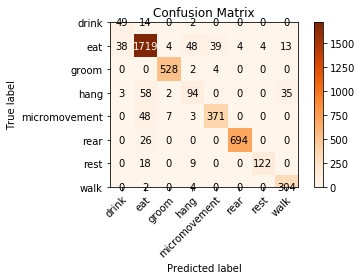

In [78]:
plot_confusion_matrix(y,y_test,classes)

In [0]:
def prepare_data(list_frames):
    #print(filename)
    nframe=len(list_frames)
    #print(nframe)
    bAppend = False 
    if(nframe>16):
      s = np.random.randint(int(nframe/16))+1
      frames=[x*s for x in range(16)]
    else:
      #print("Insufficient %d frames in video %s, appending the frames" %(nframe,filename))
      bAppend = True
      frames = [x for x in range(int(nframe))] 
    framearray = []
    opticarray=[]
    
    if not bAppend:
      #print(i,frames[i])
      for j in frames:
        f = list_frame[j]
        f = cv2.resize(f,(120,190))
        framearray.append(cv2.cvtColor(f,cv2.COLOR_BGR2GRAY))
    
    else:
      frame=''
      for j in frames:
        f = list_frame[j]
        f = cv2.resize(f,(120,190))
        framearray.append(cv2.cvtColor(f,cv2.COLOR_BGR2GRAY))
      frame=framearray[-1]  
      while len(framearray)<16:
        framearray.append(frame)

    for i in range(1,len(framearray)):
      flow=cv2.calcOpticalFlowFarneback(framearray[i-1],framearray[i],flow=None,pyr_scale=0.5,levels=5,winsize=11,iterations=10,poly_n=5,poly_sigma=1.1,flags=0)
      flow_x=np.array(flow[...,0])
      flow_y=np.array(flow[...,1])
      flow_temp = flow_x+flow_y
      opticarray.append(flow_temp)
    
    for i in range(len(framearray)):
      framearray[i]=framearray[i]/255
    framearray = np.array(framearray)
    opticarray = np.array(opticarray)
    framearray = np.expand_dims(framearray,0)
    opticarray = np.expand_dims(opticarray,0)
    framearray = framearray.transpose((0,2,3,1))
    opticarray = opticarray.transpose((0,2,3,1))
    framearray = np.expand_dims(framearray,-1)  
    opticarray = np.expand_dims(opticarray,-1)
    return np.array(framearray),np.array(opticarray)

In [0]:
def make_prediction(list_frame):
  frame,opticarray = prepare_data(list_frame)
  y = model.predict({'Input1':frame,'Input2':opticarray})
  y = np.argmax(y,axis=-1)
  return classes[int(y)]

In [25]:
cap = cv2.VideoCapture('/content/drive/My Drive/Train_Dataset/prediction_new.avi')
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('/content/drive/My Drive/Train_Dataset/predicted_new.avi',fourcc,30.0,(360,240))
list_frame=[]
font = cv2.FONT_HERSHEY_SIMPLEX

index=0
start_index=0
while cap.isOpened():
  ret,frame = cap.read()
  if ret:
    if len(list_frame)==16:
      prediction = make_prediction(list_frame)
      for i in range(8):
        f = list_frame.pop(0)
        cv2.putText(f,prediction,(30,30),font,1,(255,255,255),2,cv2.LINE_AA)
        out.write(cv2.resize(f,(360,240)))
      list_frame.append(frame)
    else:
      list_frame.append(frame)
    index+=1
    print(index)  
  else:
    break

cap.release()
out.release()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
